In [1]:
import os
import math
import pickle
import tqdm
from multiprocessing import Pool

import numpy as np
import pandas as pd
import cvxpy as cp
import torch
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

from src.mSSRM_PGA import mSSRM_PGA
from src.utils import preprocess_data, preprocess_backtest_data
from src.backtest import aggregate_weights, backtest, backtest_baseline
from src.portfolio import MeanVarianceWeightCollection

device = torch.device('cuda:0')

In [2]:
sns.set()

In [3]:
backtest_start = '2019-11'
backtest_end = '2024-11'
trading_cost = 0.004
lagging = 2

In [4]:
universes = ['universe1', 'universe2']
ports = ['MaxSortino', 'OneHot']
models = ['Mamba', 'TRF', 'LSTM']
optimizers = ['sophia']

In [5]:
universe1_backtest_yearmons, universe1_backtest_data = preprocess_backtest_data(f'data/universe1.csv')
universe2_backtest_yearmons, universe2_backtest_data = preprocess_backtest_data(f'data/universe2.csv')

In [6]:
directory = 'result/'
for universe in universes:
    for port in ports:
        file_name = universe + '_weights_' + port.lower()
        if os.path.exists(directory + file_name + '.pkl'):
            with open(directory + file_name + '.pkl', 'rb') as f:
                object = pickle.load(f)
            exec(file_name + ' = object')
        else:
            print(file_name)

In [7]:
directory = 'result/'
for universe in universes:
    for port in ports:
        for model in models:
            for optimizer in optimizers:
                file_name = universe + '_' + port.lower() + '_' + model.lower() + '_' + optimizer + '_all_weights'
                if os.path.exists(directory + file_name + '.pkl'):
                    with open(directory + file_name + '.pkl', 'rb') as f:
                        object = pickle.load(f)
                    exec(file_name + ' = object')
                else:
                    print(file_name)

In [8]:
yearmons = universe1_backtest_yearmons
data = universe1_backtest_data

universe1_baseline_backtest = backtest_baseline(yearmons, data, backtest_start, trading_cost, lagging)

weights = pd.DataFrame(index = yearmons, columns = data['log_tr'].columns, dtype = float).loc[backtest_start:]
for yearmon in tqdm.tqdm(yearmons):
    if yearmon < backtest_start:
        continue
    matR = torch.tensor(data['log_tr'].loc[data.index < yearmon].iloc[-252:].fillna(0).values, dtype = torch.float, device = device)
    weights.loc[yearmon] = mSSRM_PGA(m = len(weights.columns), iternum = 1e4, tol = 1e-5, matR = matR, vecmu = matR.mean(0)).cpu().numpy()

universe1_baseline_backtest['mSSRM_PGA'] = backtest(yearmons, data, weights, backtest_start, trading_cost, lagging)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 683/683 [00:13<00:00, 49.72it/s]


<Axes: xlabel='date'>

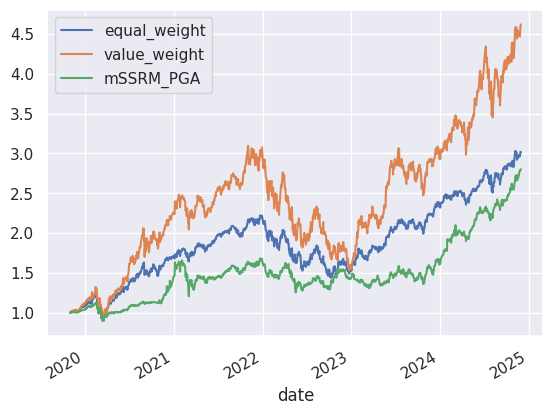

In [9]:
universe1_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().plot()

In [10]:
universe1_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().iloc[-1]

equal_weight    3.014765
value_weight    4.620447
mSSRM_PGA       2.799509
Name: 2024-11-29 00:00:00, dtype: float64

In [11]:
universe1_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe1_baseline_backtest.loc[backtest_start:backtest_end].std() * np.sqrt(252)

equal_weight    0.884195
value_weight    0.860994
mSSRM_PGA       0.890471
dtype: float64

In [12]:
universe1_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe1_baseline_backtest.loc[backtest_start:backtest_end].clip(upper=0).std() * np.sqrt(252)

equal_weight    1.391951
value_weight    1.362838
mSSRM_PGA       1.435299
dtype: float64

In [13]:
yearmons = universe2_backtest_yearmons
data = universe2_backtest_data

universe2_baseline_backtest = backtest_baseline(yearmons, data, backtest_start, trading_cost, lagging)

weights = pd.DataFrame(index = yearmons, columns = data['log_tr'].columns, dtype = float).loc[backtest_start:]
for yearmon in tqdm.tqdm(yearmons):
    if yearmon < backtest_start:
        continue
    matR = torch.tensor(data['log_tr'].loc[data.index < yearmon].iloc[-252:].fillna(0).values, dtype = torch.float, device = device)
    weights.loc[yearmon] = mSSRM_PGA(m = len(weights.columns), iternum = 1e4, tol = 1e-5, matR = matR, vecmu = matR.mean(0)).cpu().numpy()

universe2_baseline_backtest['mSSRM_PGA'] = backtest(yearmons, data, weights, backtest_start, trading_cost, lagging)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:32<00:00,  8.77it/s]


<Axes: xlabel='date'>

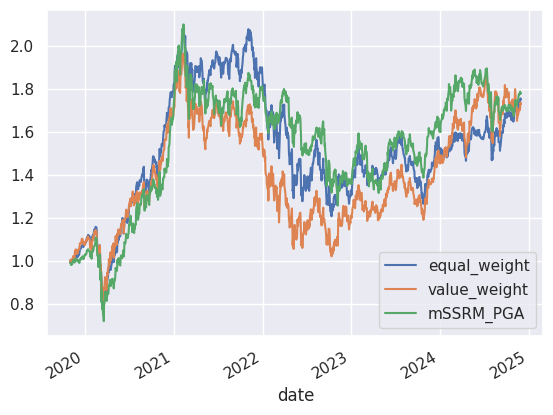

In [14]:
universe2_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().plot()

In [15]:
universe2_baseline_backtest.loc[backtest_start:backtest_end].apply(np.exp).cumprod().iloc[-1]

equal_weight    1.749401
value_weight    1.728056
mSSRM_PGA       1.777448
Name: 2024-11-29 00:00:00, dtype: float64

In [16]:
universe2_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe2_baseline_backtest.loc[backtest_start:backtest_end].std() * np.sqrt(252)

equal_weight    0.416116
value_weight    0.354075
mSSRM_PGA       0.436826
dtype: float64

In [17]:
universe2_baseline_backtest.loc[backtest_start:backtest_end].mean() / universe2_baseline_backtest.loc[backtest_start:backtest_end].clip(upper=0).std() * np.sqrt(252)

equal_weight    0.653039
value_weight    0.566843
mSSRM_PGA       0.687776
dtype: float64

In [32]:
for universe in universes:
    for port in ports:
        for model in models:
            for optimizer in optimizers:
                try:
                    object_name = universe + '_' + port.lower() + '_' + model.lower() + '_' + optimizer + '_all_weights'
                    target_name = universe + '_' + port.lower() + '_' + model.lower() + '_' + optimizer + '_backtest'
                    exec(f'weights = aggregate_weights({universe}_backtest_yearmons, {universe}_backtest_data, {object_name}, backtest_start)')
                    exec(f'{target_name} = backtest({universe}_backtest_yearmons, {universe}_backtest_data, weights, backtest_start, trading_cost, lagging)')
                except:
                    print(target_name)
                    continue

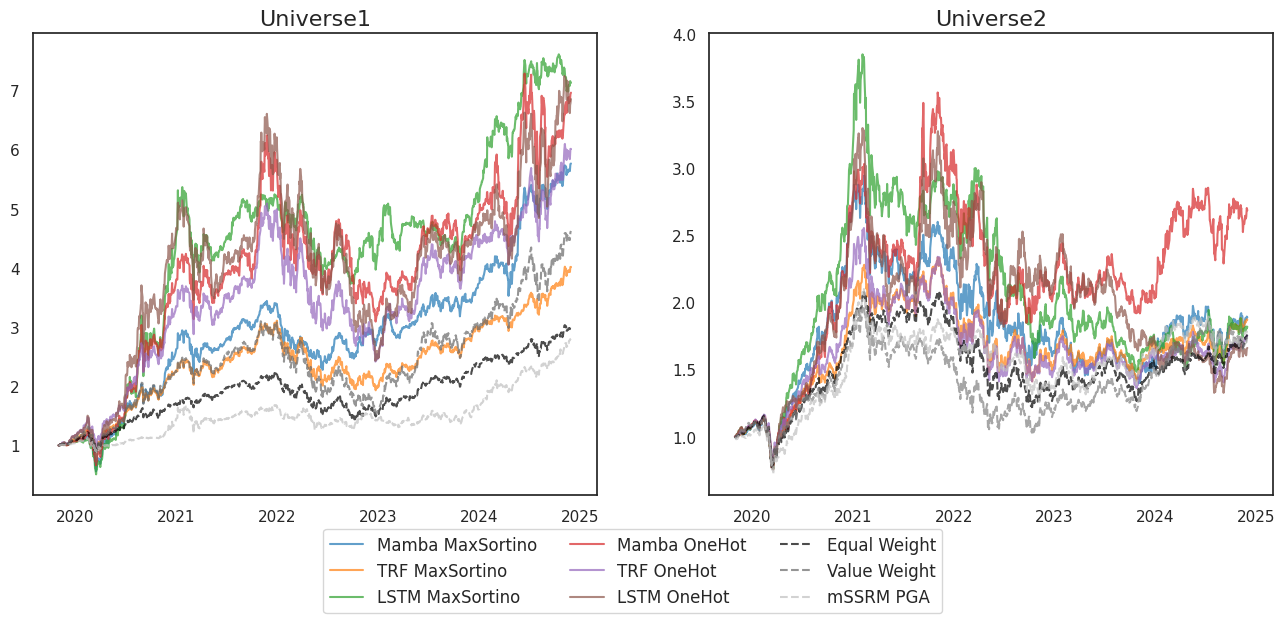

In [33]:
sns.set_style(style='white')

colormap = mpl.colormaps['tab10']
alpha = 0.7

fig = plt.figure(figsize = (16, 6))

mode = 'Monthly'

ax = plt.subplot(1, 2, 1)

universe = 'Universe1'
ind = 0
for port in ports:
    for model in models:
        object_name = universe.lower() + '_' + port.lower() + '_' + model.lower() + '_sophia_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), color = colormap(ind), label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], '--', color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], '--', color = 'dimgray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'silver',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title(f'{universe}', fontsize = 16)

fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

ax = plt.subplot(1, 2, 2)


universe = 'Universe2'
ind = 0
for port in ports:
    for model in models:
        object_name = universe.lower() + '_' + port.lower() + '_' + model.lower() + '_sophia_backtest'
        try:
            ax.plot(eval(object_name).loc[backtest_start:backtest_end].apply(np.exp).cumprod(), color = colormap(ind), label = model + ' ' + port, alpha = alpha)
        except:
            continue
        ind += 1

baseline = eval(f'{universe.lower()}_baseline_backtest').loc[backtest_start:backtest_end].apply(np.exp).cumprod()

ax.plot(baseline['equal_weight'], '--', color = 'black', label = 'Equal Weight', alpha = alpha)
ax.plot(baseline['value_weight'], '--', color = 'gray',  label = 'Value Weight', alpha = alpha)
ax.plot(baseline['mSSRM_PGA'], '--', color = 'silver',  label = 'mSSRM PGA', alpha = alpha)

ax.set_title(f'{universe}', fontsize = 16)


plt.show()

In [34]:
universe = 'universe1'
for port in ports:
    for model in models:
        object_name = universe + '_' + port.lower() + '_' + model.lower() + '_sophia_backtest'
        object = eval(object_name).loc[backtest_start:backtest_end]
        print(
            object_name,
            object.apply(np.exp).prod().iloc[0],
            (object.mean() / object.std()).iloc[0] * np.sqrt(252),
            (object.mean() / object.clip(upper=0).std()).iloc[0] * np.sqrt(252),
        )

universe1_maxsortino_mamba_sophia_backtest 5.760255416469351 1.0073185043328228 1.5779624997022994
universe1_maxsortino_trf_sophia_backtest 4.013864572827573 0.9816020544659975 1.546652337024496
universe1_maxsortino_lstm_sophia_backtest 7.123277469001376 0.9380567043701923 1.5102349750163833
universe1_onehot_mamba_sophia_backtest 6.957542667603025 0.8686803005715785 1.4106247075195277
universe1_onehot_trf_sophia_backtest 6.0074374044115695 0.9538785265015904 1.5331588495976705
universe1_onehot_lstm_sophia_backtest 6.848297707684544 0.755187041551406 1.237862006225389


In [35]:
universe = 'universe2'
for port in ports:
    for model in models:
        object_name = universe + '_' + port.lower() + '_' + model.lower() + '_sophia_backtest'
        object = eval(object_name).loc[backtest_start:backtest_end]
        print(
            object_name,
            object.apply(np.exp).prod().iloc[0],
            (object.mean() / object.std()).iloc[0] * np.sqrt(252),
            (object.mean() / object.clip(upper=0).std()).iloc[0] * np.sqrt(252),
        )

universe2_maxsortino_mamba_sophia_backtest 1.887346154893143 0.39796271557520724 0.6462380824603623
universe2_maxsortino_trf_sophia_backtest 1.8704687853587665 0.44736247922651223 0.7136880776416872
universe2_maxsortino_lstm_sophia_backtest 1.8178545495194505 0.352809785939697 0.5748209982367997
universe2_onehot_mamba_sophia_backtest 2.6850823780926416 0.5307103236763319 0.894539582440059
universe2_onehot_trf_sophia_backtest 1.7513171130806129 0.36779279600954773 0.5873438496163602
universe2_onehot_lstm_sophia_backtest 1.6599056058019155 0.25733509710033114 0.43092273403518383
